In [1]:
import scanpy as sc

adata = sc.read_h5ad(
    '../data/tcells.tissue.ad.integrated.clustered.h5ad'
)
adata.X = adata.layers['counts'].copy()
adata

AnnData object with n_obs × n_vars = 61764 × 21750
    obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score', 'nFeature_RNA', 'nCount_RNA', 'percent_mt', 'percent_ribo', 'qc_pass', '_scvi_batch', '_scvi_labels', 'leiden_scvi_0.25', 'coarse_cell_types', 'leiden_scvi_0.3', 't_cell_types'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'neighbors', 'umap'
    obsm: 'X_scvi', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

IOStream.flush timed out
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
IOStream.flush timed out
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/daniel.malzl/.local/lib/python3.9/site-packages/s

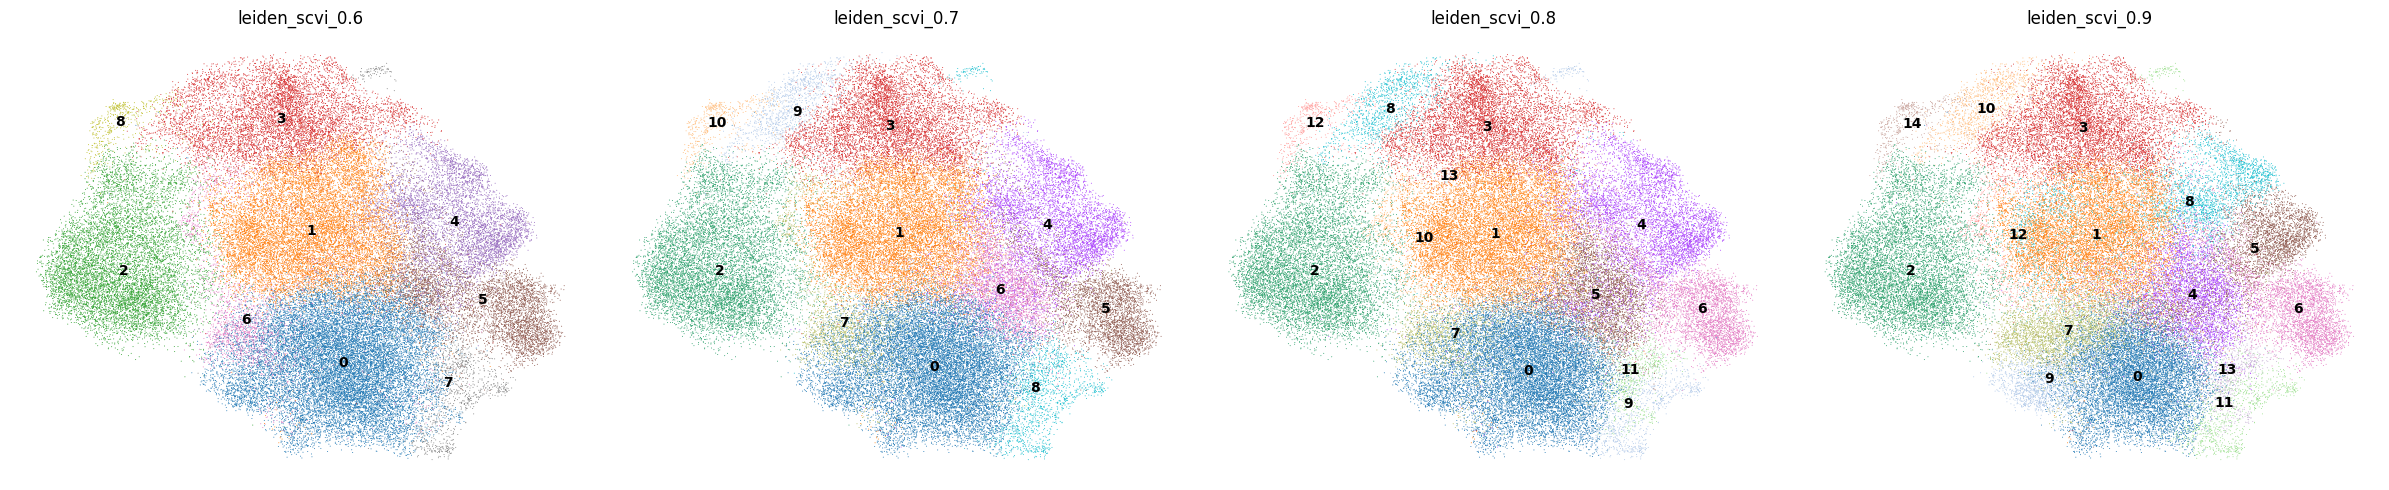

In [4]:
%matplotlib inline
from sctools import plot
import matplotlib.pyplot as plt

fig, axs = plot.integrate.plot_leiden_clusterings(
    {'tcells.tissue.ad': adata},
    [0.6, 0.7, 0.8, 0.9],
    legend_loc = 'on data'
)
plt.show()

In [2]:
res = 0.7
sc.tl.leiden(
    adata,
    resolution = res,
    key_added = f'leiden_scvi_{res}',
)

IOStream.flush timed out


/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


(<Figure size 600x1000 with 3 Axes>,
 array([<Axes: title={'center': 'tcells.tissue.ad'}, xlabel='UMAP1', ylabel='UMAP2'>,
        <Axes: title={'center': 'CD4'}, xlabel='UMAP1', ylabel='UMAP2'>],
       dtype=object))

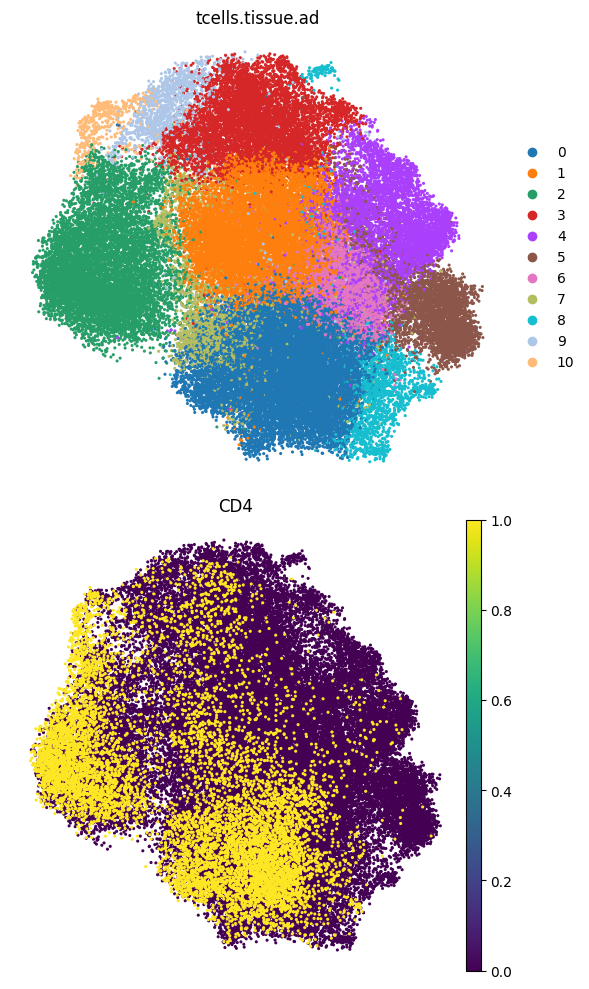

In [28]:
%matplotlib inline
import scanpy as sc
from sctools import plot

adata.X = adata.layers['counts']
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
plot.integrate.plot_clustering_and_expression(
    {'tcells.tissue.ad': adata},
    {'tcells.tissue.ad': f'leiden_scvi_{res}'},
    ['CD4'],
    [
        {'size': 20},
        {'vmax': 1, 'size': 20}
    ]
)

In [3]:
import pandas as pd


def rank_genes_group_to_data_frame(adata, rank_keys, groupby, n_genes):
    groups = adata.obs[groupby].cat.categories
    rank_results = []
    for k in rank_keys:
        rank_data = adata.uns['rank_genes_groups'][k]
        rank_results.append(
            pd.DataFrame({g: rank_data[g][:n_genes] for g in groups}).melt(value_name = k, var_name = 'group')
        )
    
    df = pd.concat(
        [rank_results[0]] + [rank_res.iloc[:, 1] for rank_res in rank_results[1:]],
        axis = 1
    )
    return df


rank_keys = ['names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj']
n_genes = 100
k = 'tcells.tissue.ad'
groupby = f'leiden_scvi_{res}'
adata.X = adata.layers['counts']
adata.layers['cpm'] = sc.pp.normalize_total(
    adata,
    target_sum = 1e4,
    inplace = False
)['X']
adata.layers['logcpm'] = sc.pp.log1p(
    adata.layers['cpm'],
    copy = True
)
sc.tl.rank_genes_groups(
    adata, 
    groupby, 
    use_raw = False,
    layer = 'logcpm',
    method = 'wilcoxon'
)
rank_results = rank_genes_group_to_data_frame(
    adata, 
    rank_keys, 
    groupby, 
    n_genes = n_genes
)
rank_results.to_csv(
    f'../markers/{k}.rank_genes_groups_{groupby}_logcpm.tsv',
    sep = '\t',
    index = False
)

In [2]:
import pandas as pd
genes = pd.read_csv(
    '../resource/Th2vsTh17_genes.txt',
    sep = '\t'
)
score_gene_dict = {
    k: group for k, group in genes.groupby('helper_subset')
}
score_gene_dict

{'Th17_Th1':      gene helper_subset
 0    RORC      Th17_Th1
 1    RORA      Th17_Th1
 2   IL17A      Th17_Th1
 3   IL17F      Th17_Th1
 4    CCR6      Th17_Th1
 5   STAT3      Th17_Th1
 6    BATF      Th17_Th1
 7    IL21      Th17_Th1
 8    IL32      Th17_Th1
 9    CCL5      Th17_Th1
 10   IL22      Th17_Th1
 11    LTA      Th17_Th1
 12   IFNG      Th17_Th1
 13  CXCR3      Th17_Th1,
 'Th2':       gene helper_subset
 14   GATA3           Th2
 15   PPARG           Th2
 16     VDR           Th2
 17   IL6ST           Th2
 18     IL4           Th2
 19     IL5           Th2
 20     IL6           Th2
 21    IL13           Th2
 22  IL1RL1           Th2
 23  IGFBP7           Th2
 24    IL4R           Th2
 25  STAT5B           Th2
 26  STAT5A           Th2
 27   STAT6           Th2}

In [6]:
genes_in_data = set(adata.var.index)
for key, gene_set in score_gene_dict.items():
    gene_set = set(gene_set.gene)
    print(key, ', '.join(genes_in_data & gene_set))

Th17_Th1 IL22, IL17A, IL32, IL17F, RORC, IL21, STAT3, LTA, IFNG, CCR6, CXCR3, CCL5, RORA, BATF
Th2 IL6ST, GATA3, IL6, STAT6, IGFBP7, STAT5B, IL4R, PPARG, VDR, IL13, IL1RL1, IL4, STAT5A


In [7]:
from sctools import score

adata.X = adata.layers['counts']
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)

score_frames = {
    k: score.gene_module_score(adata, score_genes.gene)
    for k, score_genes
    in score_gene_dict.items()
}
score_frames

{'Th17_Th1': array([-0.11173443,  0.02780721,  0.23850796, ...,  0.15982741,
         0.46973136, -0.06129375], dtype=float32),
 'Th2': array([-0.1521181 , -0.10901403, -0.07810038, ..., -0.03832358,
         0.11711474, -0.01901886], dtype=float32)}

In [35]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

cluster_key = 'leiden_scvi_0.7'

score_df = pd.DataFrame(
    score_frames
)
score_df[cluster_key] = adata.obs[cluster_key].values
score_df_melt = score_df.melt(
    id_vars = [cluster_key],
    value_vars = score_frames.keys()
)
score_df_melt

,leiden_scvi_0.7,variable,value
0,0,Th17_Th1,-0.111734
1,4,Th17_Th1,0.027807
2,0,Th17_Th1,0.238508
3,0,Th17_Th1,0.115706
4,8,Th17_Th1,0.306110
...,...,...,...
123523,0,Th2,0.057440
123524,9,Th2,0.122130
123525,4,Th2,-0.038324
123526,9,Th2,0.117115


In [38]:
def subsample_dataframe(df, groupby, n_samples_per_group):
    subsampled_frames = []
    for _, group in df.groupby(groupby):
        sample = np.random.choice(
            group.index,
            size = n_samples_per_group,
            replace = False
        )
        subsampled_frames.append(
            group.loc[sample, :]
        )
    
    return pd.concat(subsampled_frames)


sampled_scores = subsample_dataframe(
    score_df,
    cluster_key,
    100
)
sampled_scores_melt = sampled_scores.melt(
    id_vars = [cluster_key],
    value_vars = score_frames.keys()
)
sampled_scores_melt

,leiden_scvi_0.7,variable,value
0,0,Th17_Th1,-0.078647
1,0,Th17_Th1,0.072616
2,0,Th17_Th1,-0.000556
3,0,Th17_Th1,0.118950
4,0,Th17_Th1,0.039328
...,...,...,...
2195,10,Th2,-0.130281
2196,10,Th2,-0.191519
2197,10,Th2,-0.202880
2198,10,Th2,0.017946


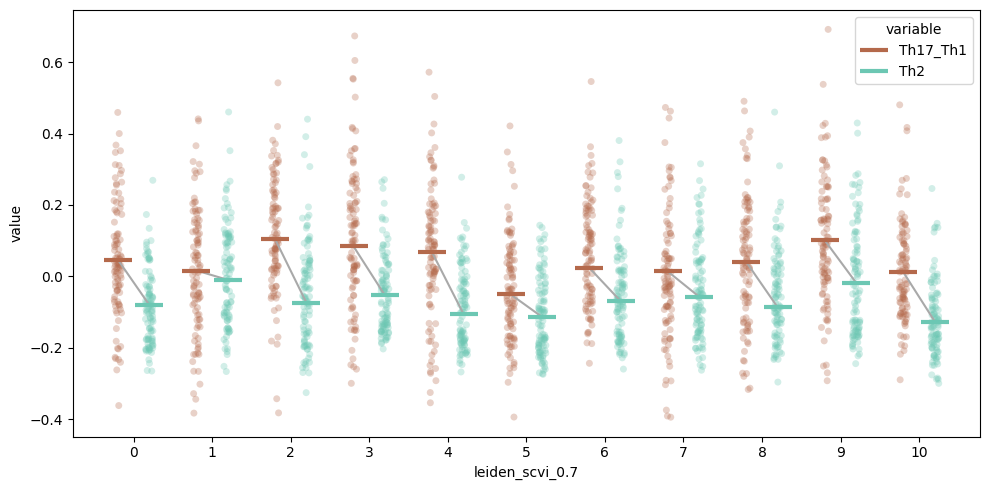

In [60]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42


fig, ax = plt.subplots()

palette = {
    'Th17_Th1': '#b4694b',
    'Th2': '#6cc7b3'
}
sns.stripplot(
    data = sampled_scores_melt, 
    y = 'value', 
    x = cluster_key, 
    hue = 'variable',
    dodge = True, 
    alpha = .3, 
    legend = False,
    ax = ax,
    zorder = 1,
    palette = palette
)

marker_dodge = 0.4
sns.pointplot(
    data = score_df_melt, 
    y = 'value', 
    x = cluster_key, 
    hue = 'variable',
    estimator = 'median',
    dodge = marker_dodge, 
    linestyle = 'none', 
    errorbar = None,
    marker = '_', 
    markersize = 20, 
    markeredgewidth = 3,
    ax = ax,
    zorder = 3,
    palette = palette
)

for i, (_, group) in enumerate(score_df.groupby(cluster_key)):
    th17_th1_mean = group['Th17_Th1'].median()
    th2_mean = group['Th2'].median()
    ax.plot(
        [i - marker_dodge / 2, i + marker_dodge / 2],
        [th17_th1_mean, th2_mean],
        c = 'darkgrey',
        zorder = 2
    )

fig.set_figwidth(10)
fig.set_figheight(5)
fig.tight_layout()
fig.savefig('../plots/tcells.tissue.ad.th17_th2_scores.pdf')

In [62]:
from sctools import plot

plot_dir = '../plots/'
k = 'tcells.tissue.ad'
plot.misc.generate_and_save_for_figure(
    adata,
    {
        'leiden_scvi_0.7': (None, None)
    },
    f'{plot_dir}/{k}' + '.integrated.{0}.png',
    f'{plot_dir}/{k}' + '.integrated.{0}.legend.pdf',
    size = 20,
    edgecolor = 'k',
    linewidths = 0.05
)

/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
